In [ ]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
# import seaborn as sns
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import text_to_word_sequence
!pip install nltk
!pip install tensorflow
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# Data Preparation
csv_data = pd.read_csv('extended_googleplaystore_user_reviews.csv')
csv_data = csv_data[csv_data['Translated_Review'].notna()]
p=csv_data['original_Sentiment_Polarity'].max()
q=csv_data['original_Sentiment_Polarity'].min()

print(p,q,len(csv_data))
csv_data.head()


1.0 -1.0 37427


,App,Translated_Review,sentences_count,characters_count,spaces_count,count_words,duplicates_count,chars_excl_spaces_count,emoji_count,whole_numbers_count,...,spelling_quality,spelling_quality_summarised,ease_of_reading_score,ease_of_reading_quality,ease_of_reading_summarised,grammar_check_score,grammar_check,original_Sentiment,original_Sentiment_Polarity,original_Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,2.0,122.0,20.0,22.0,6.0,102.0,0.0,1.0,...,Bad,Bad,86.20,Easy,Easy,5.0,5 issues,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,1.0,47.0,6.0,7.0,0.0,41.0,0.0,0.0,...,Very good,Good,38.99,Difficult,Difficult,0.0,No issues,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,1.0,42.0,5.0,6.0,0.0,37.0,0.0,0.0,...,Very good,Good,48.47,Difficult,Difficult,0.0,No issues,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,1.0,12.0,2.0,3.0,0.0,10.0,0.0,0.0,...,Very good,Good,119.19,Very Easy,Easy,1.0,1 issue,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,1.0,8.0,1.0,2.0,0.0,7.0,0.0,0.0,...,Very good,Good,120.21,Very Easy,Easy,0.0,No issues,Positive,1.00,0.300000


In [ ]:
class SentimentSatisfaction:
    def __init__(self,satisfaction_index):
        self.satisfaction_index = satisfaction_index
    def get_sentiment_satisfaction(self):
        if self.satisfaction_index <= -0.6:
            return 0
        elif self.satisfaction_index <= -0.2:
            return 1
        elif self.satisfaction_index <= 0.2:
            return 2
        elif self.satisfaction_index <= 0.6:
            return 3
        else:
            return 4

satisfaction_class = {
    "very_negative":0,
    "negative":1,
    "neutral":2,
    "positive":3,
    "very_positive":4
    }
csv_data['result'] = csv_data['original_Sentiment_Polarity'].apply(lambda x:SentimentSatisfaction(x).get_sentiment_satisfaction())

In [ ]:
data = csv_data.copy()
data = csv_data[['Translated_Review','result','original_Sentiment_Polarity']]
# Shuffle Row Order
# data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Translated_Review,result,original_Sentiment_Polarity
0,I like eat delicious food. That's I'm cooking ...,4,1.00
1,This help eating healthy exercise regular basis,3,0.25
3,Works great especially going grocery store,3,0.40
4,Best idea us,4,1.00
5,Best way,4,1.00


In [ ]:
#-------------------------------------------------------------------------------------------------------------
# Cleaning and Wrangling of Data
#-------------------------------------------------------------------------------------------------------------

# Remove URLs and mentions from text
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: re.sub(r'http\S+', '', x))
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: re.sub(r'@\S+', '', x))



# Remove non-alphabetic characters and convert to lowercase
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x.lower()))

# Tokenize text
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: nltk.word_tokenize(x))
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: [value for value in x if not re.match(r'^-?\d+\.?\d*$', value)])


# Remove stopwords
stop_words = stopwords.words('english')
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize text
lemmatizer = WordNetLemmatizer()
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

# Join tokens back into strings
data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: ' '.join(x))
data.head()

<ipython-input-17-f2f965763b13>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: nltk.word_tokenize(x))
<ipython-input-17-f2f965763b13>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Translated_Review'] = data['Translated_Review'].apply(lambda x: [value for value in x if not re.match(r'^-?\d+\.?\d*$', value)])
<ipython-input-17-f2f965763b13>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,Translated_Review,result,original_Sentiment_Polarity
0,like eat delicious food cooking food case best...,4,1.00
1,help eating healthy exercise regular basis,3,0.25
3,work great especially going grocery store,3,0.40
4,best idea u,4,1.00
5,best way,4,1.00


In [ ]:
# For Machine Learning
m_data = data.copy()
review_data = m_data['Translated_Review']
result_data = m_data['result']

In [ ]:
#-------------------------------------------------------------------------------------------------------------
# Preprocessing of Data 
#-------------------------------------------------------------------------------------------------------------

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit and transform the data using the vectorizer object
c_vectorized_data = vectorizer.fit_transform(review_data)




In [ ]:
# Create a Tf-IDF Vectorizer object
t_vectorized_data = TfidfVectorizer(max_features=10000, stop_words='english')
t_vectorized_data.fit(review_data)

# Fit and transform the data using the vectorizer object
t_vectorized_data = vectorizer.transform(review_data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(t_vectorized_data, result_data, test_size=0.2,random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
<ipython-input-20-eb124adda724>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


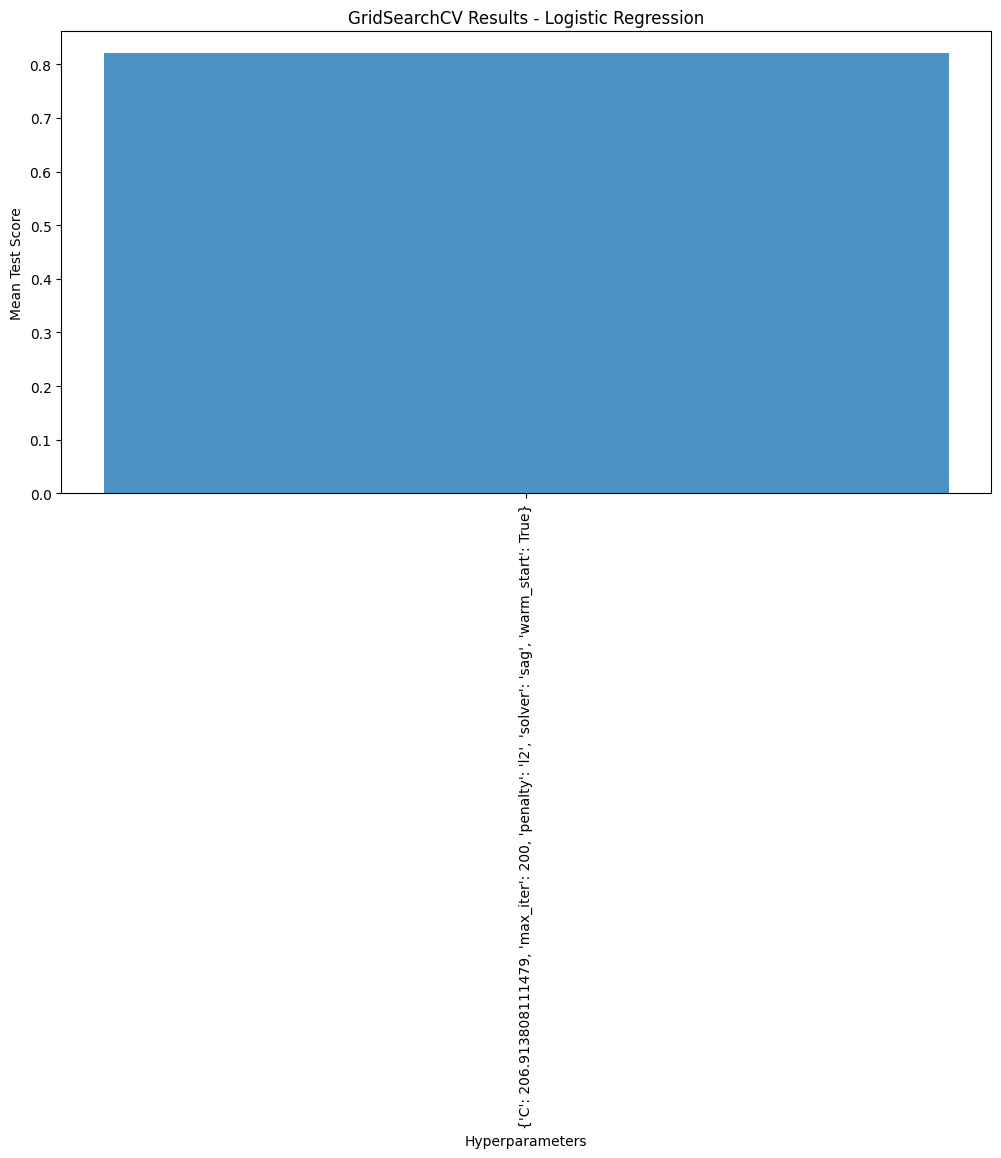

Accuracy: 0.8403686882180069


In [ ]:
# Logistic Regression and Count Vectorizer
# Split the dataset into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(c_vectorized_data, result_data, test_size=0.2,random_state=42)
# Train a machine learning model on the training set
lr_model = LogisticRegression()

# For HyperParameter Tuning
param_grid={
    'warm_start': [True], 
    'solver': ['sag'], 
    'penalty': ['l2'], 
    'max_iter': [200], 
    'C': [206.913808111479]
}

# Perform random search with cross-validation
grid_search = GridSearchCV(lr_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_lr, y_train_lr)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions
y_pred_lr = best_model.predict(X_test_lr)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_lr, y_pred_lr)

# For Plot
results = grid_search.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']
# Evaluate the accuracy of the model
# Plot the accuracy scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(params)), mean_test_scores, align='center', alpha=0.8)
plt.xticks(range(len(params)), [str(p) for p in params], rotation='vertical')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Test Score')
plt.title('GridSearchCV Results - Logistic Regression')
plt.tight_layout()
plt.show()
print("Accuracy:", accuracy)

In [ ]:
# For TFIDF and Support Vector Machine
# Train a machine learning model on the training set
t_l_model = SVC()

t_l_model.fit(X_train, y_train)
y_pred = t_l_model.predict(X_test)

# Use the best model to make predictions
y_pred = t_l_model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [ ]:
# For Deep Learning
d_data = data.copy()
d_data = d_data[['Translated_Review','result']]
texts = d_data['Translated_Review']
sentiment = d_data['result']

# consider only the top 10000 words
max_words = 20000 

# Tokenize the texts
tokenizer = Tokenizer(num_words=17599)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences to have the same length
max_len = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=301)


Epoch 1/10
936/936 [==============================] - 903s 954ms/step - loss: 0.7368 - accuracy: 0.6910 - val_loss: 0.4954 - val_accuracy: 0.8086
Epoch 2/10
936/936 [==============================] - 869s 929ms/step - loss: 0.3558 - accuracy: 0.8708 - val_loss: 0.3952 - val_accuracy: 0.8561
Epoch 3/10
936/936 [==============================] - 858s 917ms/step - loss: 0.2302 - accuracy: 0.9254 - val_loss: 0.4230 - val_accuracy: 0.8489
Epoch 4/10
936/936 [==============================] - 849s 907ms/step - loss: 0.1712 - accuracy: 0.9456 - val_loss: 0.4238 - val_accuracy: 0.8659
Epoch 5/10
936/936 [==============================] - 856s 915ms/step - loss: 0.1309 - accuracy: 0.9598 - val_loss: 0.4710 - val_accuracy: 0.8686
Epoch 6/10
936/936 [==============================] - 807s 863ms/step - loss: 0.1056 - accuracy: 0.9671 - val_loss: 0.5375 - val_accuracy: 0.8607
Epoch 7/10
936/936 [==============================] - 798s 852ms/step - loss: 0.0909 - accuracy: 0.9725 - val_loss: 0.5220 -

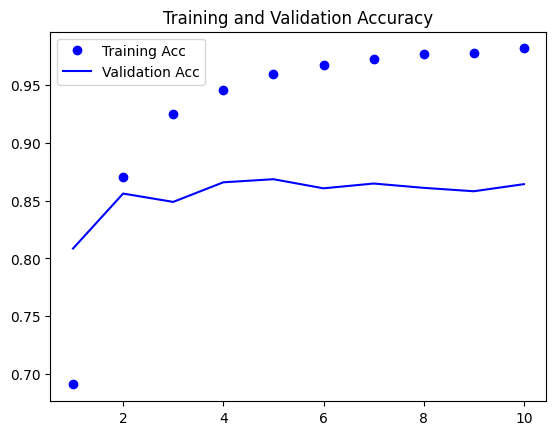

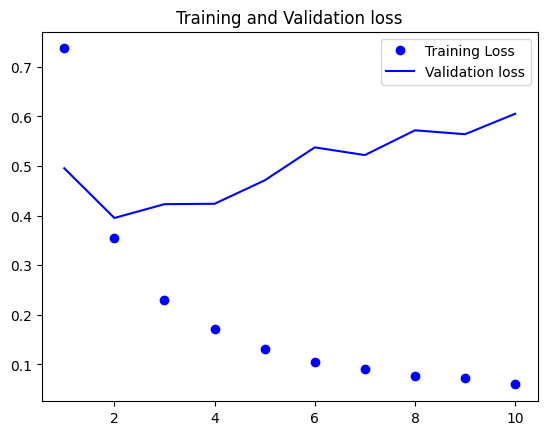

In [ ]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(padded_sequences, sentiment, test_size=0.2, random_state=42)

# Define the BiLSTM model
bi_model = Sequential()
bi_model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_len))
bi_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bi_model.add(Bidirectional(LSTM(64)))
bi_model.add(Dense(64, activation='relu'))
bi_model.add(Dense(5, activation='softmax'))  # 5 classes for fuzzy sentiment analysis

# Compile the bi_model
bi_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the bi_model
history = bi_model.fit(X_train_bi, y_train_bi, validation_data=(X_test_bi, y_test_bi), epochs=10, batch_size=32)

accuracy = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
# For Polarity Score Estimation
p_data = data.copy()
sia = SentimentIntensityAnalyzer()
sentiment_scores = []
for review in p_data['Translated_Review']:
    scores = sia.polarity_scores(review)
    sentiment_scores.append(scores['compound'])
p_data['sentiment_score'] = sentiment_scores
p_data['predicted_label'] = p_data['sentiment_score'].apply(lambda x:SentimentSatisfaction(x).get_sentiment_satisfaction())

accuracy = accuracy_score(p_data['result'], p_data['predicted_label'])
print(p_data)
print("Accuracy:", accuracy)

In [ ]:
# Compounding LogisticRegression and BiLSTM
# Convert the BiLSTM predictions to a 1D array
lr_predictions = grid_search.predict(X_test_lr)
bilstm_predictions = bi_model.predict(X_test_bi)
y_test_lr = y_test_lr  # y_test_lr corresponding to X_test_lr for Logistic Regression
y_test_bilstm = y_test_bi  # y_test_bilstm corresponding to X_test_bilstm for BiLSTM
bilstm_predictions = np.squeeze(bilstm_predictions)

# Convert the Logistic Regression predictions to match the shape of the BiLSTM predictions
lr_predictions = np.expand_dims(lr_predictions, axis=1)

# Print the accuracy of each model
print("Logistic Regression Accuracy:", np.mean(lr_predictions == y_test_lr))
print("BiLSTM Accuracy:", np.mean(bilstm_predictions == y_test_bi))

# Define the ensemble predictions
ensemble_predictions = np.round((lr_predictions + bilstm_predictions) / 2).astype(int)

# Print the accuracy of the ensemble model
print("Ensemble Model Accuracy:", np.mean(ensemble_predictions == y_test_lr)) # Assuming using y_test_lr for evaluation